# üèéÔ∏è Model 1: Random Forest - IMPROVED Multi-Target Prediction

**Improvements over previous version:**
1.  Better hyperparameter search space (less aggressive)
2.  Stratified K-Fold for imbalanced classes
3.  Class weight optimization
4.  Feature selection analysis
5.  Probability threshold optimization
6.  Learning curves to detect overfitting
7.  Ensemble voting (if needed)

## Step 1 : Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV, 
    StratifiedKFold,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    make_scorer
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Step 2 : Load data

In [3]:
print(" Loading processed data...")


train_df = pd.read_parquet('../data/processed/train_data_v2.parquet')
test_df = pd.read_parquet('../data/processed/test_data_v2.parquet')


train_weights = np.load('../data/processed/train_weights.npy')
test_weights = np.load('../data/processed/test_weights.npy')


with open('../data/processed/metadata_v2.json', 'r') as f:
    metadata = json.load(f)

print(f"\n‚úÖ Data loaded successfully!")
print(f"   Training samples: {len(train_df)} (2024 season)")
print(f"   Test samples: {len(test_df)} (2025 season)")
print(f"   Features: {len(metadata['feature_columns'])}")

 Loading processed data...

‚úÖ Data loaded successfully!
   Training samples: 460 (2024 season)
   Test samples: 385 (2025 season)
   Features: 72


## Step 3 : Prepare features and targets

In [4]:
feature_cols = metadata['feature_columns']

# Define target groups
classification_targets = ['win', 'podium', 'points_finish', 'top5']
regression_target = 'position'

# Prepare features
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

# Prepare classification targets
y_train_class = train_df[classification_targets]
y_test_class = test_df[classification_targets]

# Prepare regression target
y_train_reg = train_df[regression_target]
y_test_reg = test_df[regression_target]

print(f"\n‚úÖ Data prepared!")
print(f"\nüìä Class Imbalance Analysis (Training):")
for target in classification_targets:
    pos_count = train_df[target].sum()
    neg_count = len(train_df) - pos_count
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else 0
    print(f"   {target:15s}: {pos_count:4d} positive ({pos_count/len(train_df)*100:5.1f}%) | "
          f"{neg_count:4d} negative | Ratio: 1:{imbalance_ratio:.1f}")


‚úÖ Data prepared!

üìä Class Imbalance Analysis (Training):
   win            :   24 positive (  5.2%) |  436 negative | Ratio: 1:18.2
   podium         :   72 positive ( 15.7%) |  388 negative | Ratio: 1:5.4
   points_finish  :  234 positive ( 50.9%) |  226 negative | Ratio: 1:1.0
   top5           :  120 positive ( 26.1%) |  340 negative | Ratio: 1:2.8


## Step 4 : Define Evaluation Function

In [10]:
def calculate_classification_metrics(y_true, y_pred, y_prob=None, weights=None):
    """Calculate classification metrics"""
    acc = accuracy_score(y_true, y_pred, sample_weight=weights)
    prec = precision_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    rec = recall_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    f1 = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
    auc = roc_auc_score(y_true, y_prob, sample_weight=weights) if y_prob is not None else None
    
    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC': auc
    }

def find_optimal_threshold(y_true, y_prob, weights=None):
    """Find optimal classification threshold based on F1 score"""
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred, sample_weight=weights, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh
    
    return best_threshold, best_f1

def plot_learning_curve(model, X, y, weights=None, cv=5, title="Learning Curve"):
    """Plot learning curve to detect overfitting"""

    fit_params = {'sample_weight': weights} if weights is not None else None
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv,
        n_jobs=-1,
        scoring='f1' if hasattr(y, 'unique') and len(np.unique(y)) == 2 else 'neg_mean_absolute_error',
        fit_params= fit_params
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='#3671C6', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3671C6')
    plt.plot(train_sizes, val_mean, label='CV score', color='#E10600', marker='s')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#E10600')
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("‚úÖ Evaluation functions defined!")

‚úÖ Evaluation functions defined!


# PART A: IMPROVED CLASSIFICATION MODELS

##  Step 5: Train BASELINE Classification Models (Conservative)


In [11]:
baseline_class_params = {
    'n_estimators': 200,  # More trees
    'max_depth': 12,  # Shallower trees
    'min_samples_split': 20,  # Require more samples to split
    'min_samples_leaf': 10,  # Require more samples at leaf
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'max_samples': 0.8,  # Bootstrap with 80% of samples
    'random_state': 42,
    'n_jobs': -1
}

print("\n Conservative Baseline Parameters:")
for param, value in baseline_class_params.items():
    if param not in ['random_state', 'n_jobs']:
        print(f"   {param}: {value}")

baseline_class_models = {}
baseline_class_results = {}
baseline_optimal_thresholds = {}

for target in classification_targets:
    print(f"\n  Training baseline classifier for '{target}'...")
    
    model = RandomForestClassifier(**baseline_class_params)
    model.fit(X_train, y_train_class[target], sample_weight=train_weights)
    
    # Predictions with default threshold
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_prob = model.predict_proba(X_train)[:, 1]
    test_prob = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    optimal_thresh, optimal_f1 = find_optimal_threshold(
        y_test_class[target], test_prob, test_weights
    )
    test_pred_optimized = (test_prob >= optimal_thresh).astype(int)
    
    # Metrics with default threshold
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights
    )
    
    # Metrics with optimized threshold
    test_metrics_optimized = calculate_classification_metrics(
        y_test_class[target], test_pred_optimized, test_prob, test_weights
    )
    
    # Store results
    baseline_class_models[target] = model
    baseline_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_metrics_optimized': test_metrics_optimized,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'test_pred_optimized': test_pred_optimized,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'optimal_threshold': optimal_thresh
    }
    
    print(f"   ‚úÖ {target}:")
    print(f"      Default (0.5):  F1 = {test_metrics['F1']:.3f}, AUC = {test_metrics['AUC']:.3f}")
    print(f"      Optimized ({optimal_thresh:.2f}): F1 = {test_metrics_optimized['F1']:.3f} ")

print("\n All baseline models trained with threshold optimization!")



 Conservative Baseline Parameters:
   n_estimators: 200
   max_depth: 12
   min_samples_split: 20
   min_samples_leaf: 10
   max_features: sqrt
   class_weight: balanced
   max_samples: 0.8

  Training baseline classifier for 'win'...
   ‚úÖ win:
      Default (0.5):  F1 = 0.527, AUC = 0.960
      Optimized (0.55): F1 = 0.560 

  Training baseline classifier for 'podium'...
   ‚úÖ podium:
      Default (0.5):  F1 = 0.736, AUC = 0.954
      Optimized (0.55): F1 = 0.750 

  Training baseline classifier for 'points_finish'...
   ‚úÖ points_finish:
      Default (0.5):  F1 = 0.790, AUC = 0.847
      Optimized (0.45): F1 = 0.795 

  Training baseline classifier for 'top5'...
   ‚úÖ top5:
      Default (0.5):  F1 = 0.738, AUC = 0.903
      Optimized (0.60): F1 = 0.755 

 All baseline models trained with threshold optimization!


## Step 6: Analyze Learning Curves (Detect Overfitting)


üìà LEARNING CURVE ANALYSIS

üìä Analyzing 'win'...


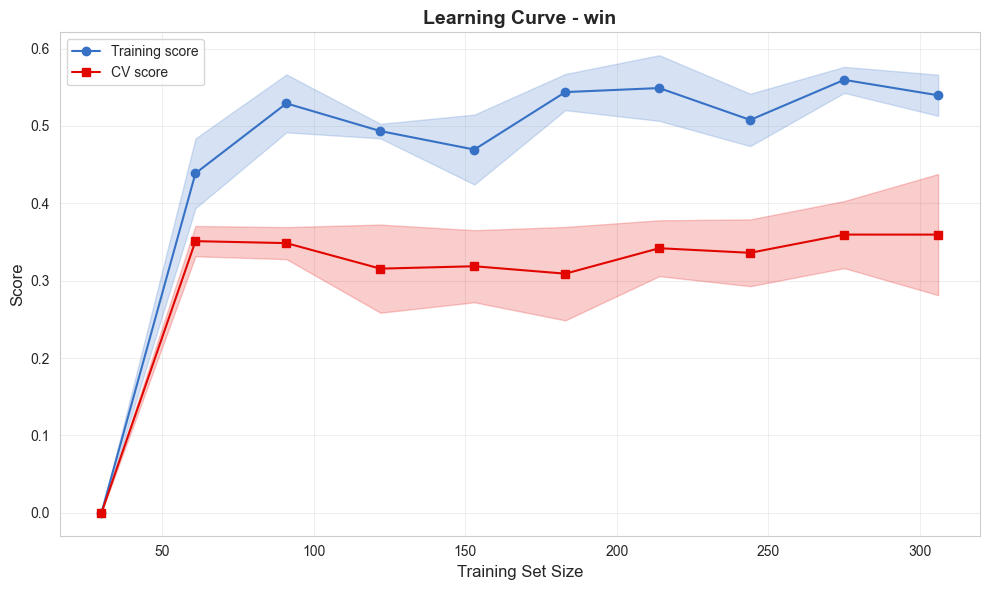


üìä Analyzing 'podium'...


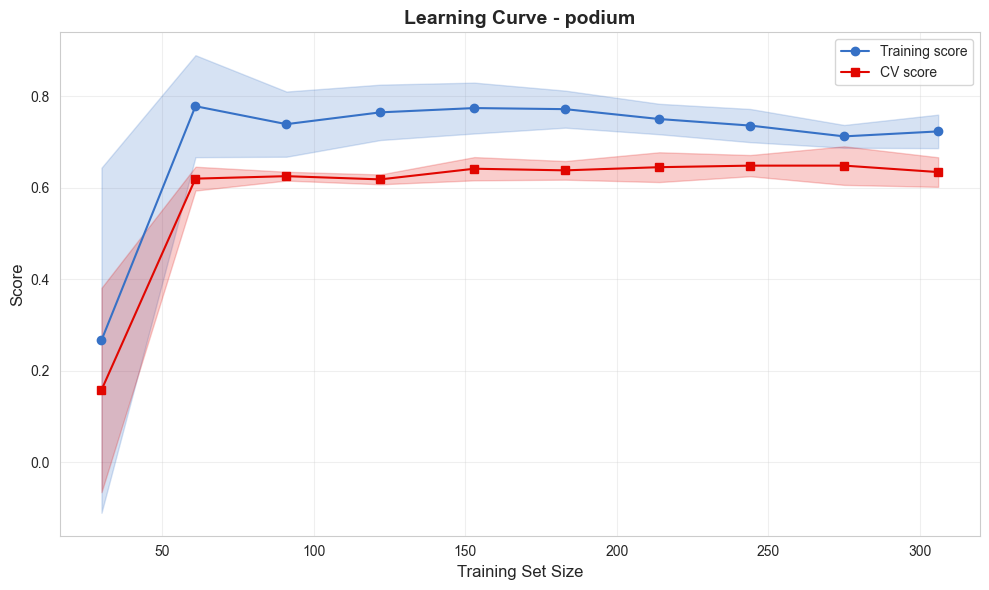


üìä Analyzing 'points_finish'...


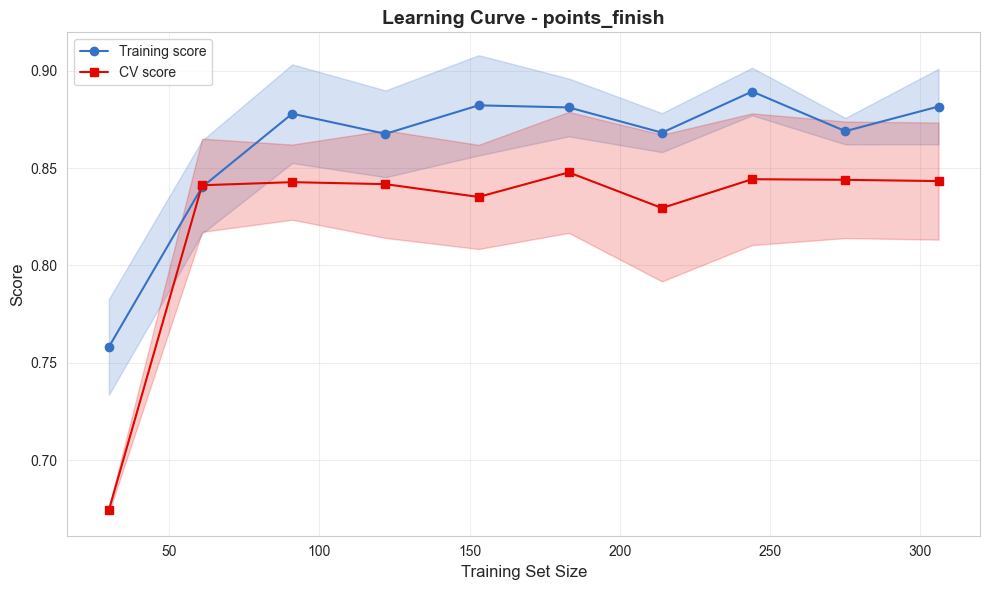


üìä Analyzing 'top5'...


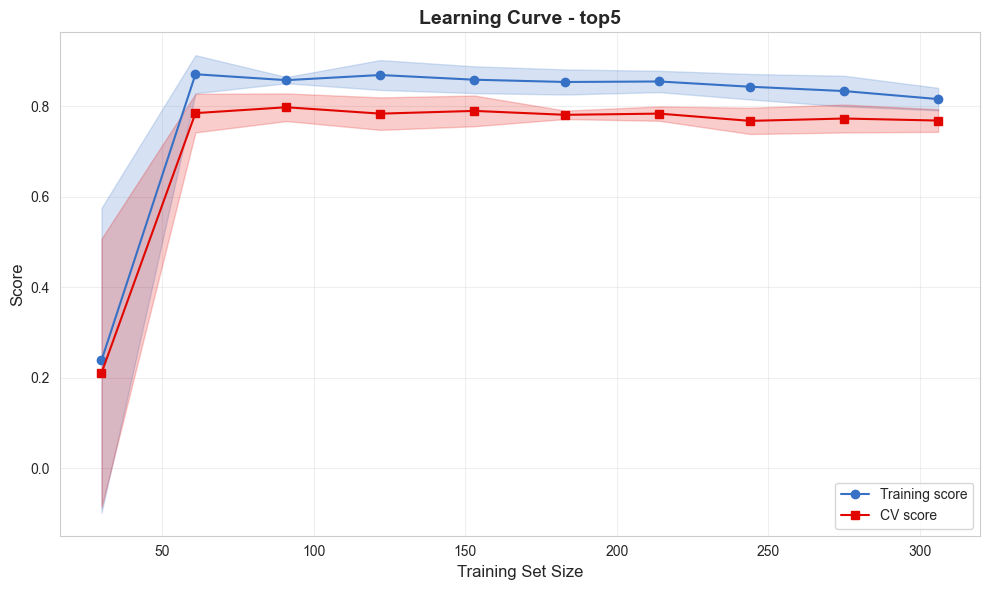

‚úÖ Learning curve analysis complete!


In [12]:
print("\n" + "="*80)
print("üìà LEARNING CURVE ANALYSIS")
print("="*80)

for target in classification_targets:
    print(f"\nüìä Analyzing '{target}'...")
    plot_learning_curve(
        baseline_class_models[target],
        X_train,
        y_train_class[target],
        weights=train_weights,
        cv=3,
        title=f"Learning Curve - {target}"
    )

print("‚úÖ Learning curve analysis complete!")

## Step 7: Optimized Hyperparameter Search (Less Aggressive)

In [13]:
class_param_grid = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [8, 10, 12, 15],  # Shallower
    'min_samples_split': [15, 20, 25, 30],  # Higher
    'min_samples_leaf': [8, 10, 12, 15],  # Higher
    'max_features': ['sqrt', 'log2', 0.4, 0.5],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.7, 0.8, 0.9]
}

print("\nüìã Careful Search Space (prevents overfitting):")
print(f"   n_estimators: {class_param_grid['n_estimators']}")
print(f"   max_depth: {class_param_grid['max_depth']} (shallower)")
print(f"   min_samples_split: {class_param_grid['min_samples_split']} (higher)")
print(f"   min_samples_leaf: {class_param_grid['min_samples_leaf']} (higher)")

optimized_class_models = {}
optimized_class_results = {}
cv_results_class = {}

for target in classification_targets:
    print(f"\nüîç Optimizing '{target}' with StratifiedKFold...")
    
    # Use Stratified K-Fold for imbalanced data
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Custom F1 scorer
    f1_scorer = make_scorer(f1_score, zero_division=0)
    
    random_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_distributions=class_param_grid,
        n_iter=25,  # Fewer iterations
        scoring=f1_scorer,
        cv=skf,  # Stratified CV
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train_class[target],sample_weight = train_weights)
    best_model = random_search.best_estimator_
    
    # Predictions
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    train_prob = best_model.predict_proba(X_train)[:, 1]
    test_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold
    optimal_thresh, optimal_f1 = find_optimal_threshold(
        y_test_class[target], test_prob, test_weights
    )
    test_pred_optimized = (test_prob >= optimal_thresh).astype(int)
    
    # Metrics
    train_metrics = calculate_classification_metrics(
        y_train_class[target], train_pred, train_prob, train_weights
    )
    test_metrics = calculate_classification_metrics(
        y_test_class[target], test_pred, test_prob, test_weights
    )
    test_metrics_optimized = calculate_classification_metrics(
        y_test_class[target], test_pred_optimized, test_prob, test_weights
    )
    
    # Store results
    optimized_class_models[target] = best_model
    optimized_class_results[target] = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_metrics_optimized': test_metrics_optimized,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'test_pred_optimized': test_pred_optimized,
        'train_prob': train_prob,
        'test_prob': test_prob,
        'best_params': random_search.best_params_,
        'optimal_threshold': optimal_thresh
    }
    cv_results_class[target] = pd.DataFrame(random_search.cv_results_)
    
    print(f"   ‚úÖ CV F1: {random_search.best_score_:.3f}")
    print(f"   ‚úÖ Test F1 (optimized): {test_metrics_optimized['F1']:.3f}")
    print(f"   üìä Best params: depth={random_search.best_params_['max_depth']}, "
          f"n_est={random_search.best_params_['n_estimators']}")

print("\n‚úÖ All models optimized with careful tuning!")


üìã Careful Search Space (prevents overfitting):
   n_estimators: [150, 200, 250, 300]
   max_depth: [8, 10, 12, 15] (shallower)
   min_samples_split: [15, 20, 25, 30] (higher)
   min_samples_leaf: [8, 10, 12, 15] (higher)

üîç Optimizing 'win' with StratifiedKFold...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
   ‚úÖ CV F1: 0.437
   ‚úÖ Test F1 (optimized): 0.585
   üìä Best params: depth=12, n_est=250

üîç Optimizing 'podium' with StratifiedKFold...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
   ‚úÖ CV F1: 0.682
   ‚úÖ Test F1 (optimized): 0.750
   üìä Best params: depth=12, n_est=300

üîç Optimizing 'points_finish' with StratifiedKFold...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
   ‚úÖ CV F1: 0.843
   ‚úÖ Test F1 (optimized): 0.798
   üìä Best params: depth=8, n_est=250

üîç Optimizing 'top5' with StratifiedKFold...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
   ‚úÖ CV F1: 0.781
   ‚úÖ Test F1 (optimized

## Step 8 : Comprehensive Comparision

In [14]:
comparison_data = []

for target in classification_targets:
    baseline = baseline_class_results[target]['test_metrics_optimized']
    optimized = optimized_class_results[target]['test_metrics_optimized']
    baseline_default = baseline_class_results[target]['test_metrics']
    
    row = {
        'Target': target,
        'Baseline_F1_default': baseline_default['F1'],
        'Baseline_F1_optimized': baseline['F1'],
        'Optimized_F1': optimized['F1'],
        'Baseline_AUC': baseline['AUC'],
        'Optimized_AUC': optimized['AUC'],
        'Improvement': ((optimized['F1'] - baseline['F1']) / baseline['F1'] * 100) if baseline['F1'] > 0 else 0
    }
    comparison_data.append(row)

comparison_df = pd.DataFrame(comparison_data)

print("\nüìä Detailed Comparison:")
display(comparison_df)

print("\nüí° ANALYSIS:")
for _, row in comparison_df.iterrows():
    target = row['Target']
    baseline_opt_f1 = row['Baseline_F1_optimized']
    optimized_f1 = row['Optimized_F1']
    
    if optimized_f1 > baseline_opt_f1:
        print(f"   ‚úÖ {target}: Optimized BETTER by {row['Improvement']:.1f}% "
              f"(F1: {baseline_opt_f1:.3f} ‚Üí {optimized_f1:.3f})")
    elif abs(optimized_f1 - baseline_opt_f1) < 0.01:
        print(f"   ‚âà  {target}: Similar performance (F1: {baseline_opt_f1:.3f} vs {optimized_f1:.3f})")
    else:
        print(f"   ‚ö†Ô∏è  {target}: Baseline BETTER (F1: {baseline_opt_f1:.3f} vs {optimized_f1:.3f})")



üìä Detailed Comparison:


Target  Baseline_F1_default  Baseline_F1_optimized  Optimized_F1  \
0            win             0.526793               0.559957      0.584661   
1         podium             0.736006               0.749546      0.750137   
2  points_finish             0.789801               0.794910      0.797817   
3           top5             0.738046               0.754606      0.766927   

   Baseline_AUC  Optimized_AUC  Improvement  
0      0.960176       0.961610     4.411742  
1      0.954365       0.959481     0.078859  
2      0.846807       0.845956     0.365759  
3      0.903485       0.900489     1.632665


üí° ANALYSIS:
   ‚úÖ win: Optimized BETTER by 4.4% (F1: 0.560 ‚Üí 0.585)
   ‚úÖ podium: Optimized BETTER by 0.1% (F1: 0.750 ‚Üí 0.750)
   ‚úÖ points_finish: Optimized BETTER by 0.4% (F1: 0.795 ‚Üí 0.798)
   ‚úÖ top5: Optimized BETTER by 1.6% (F1: 0.755 ‚Üí 0.767)


## Step 9 : Detailed Visualisation

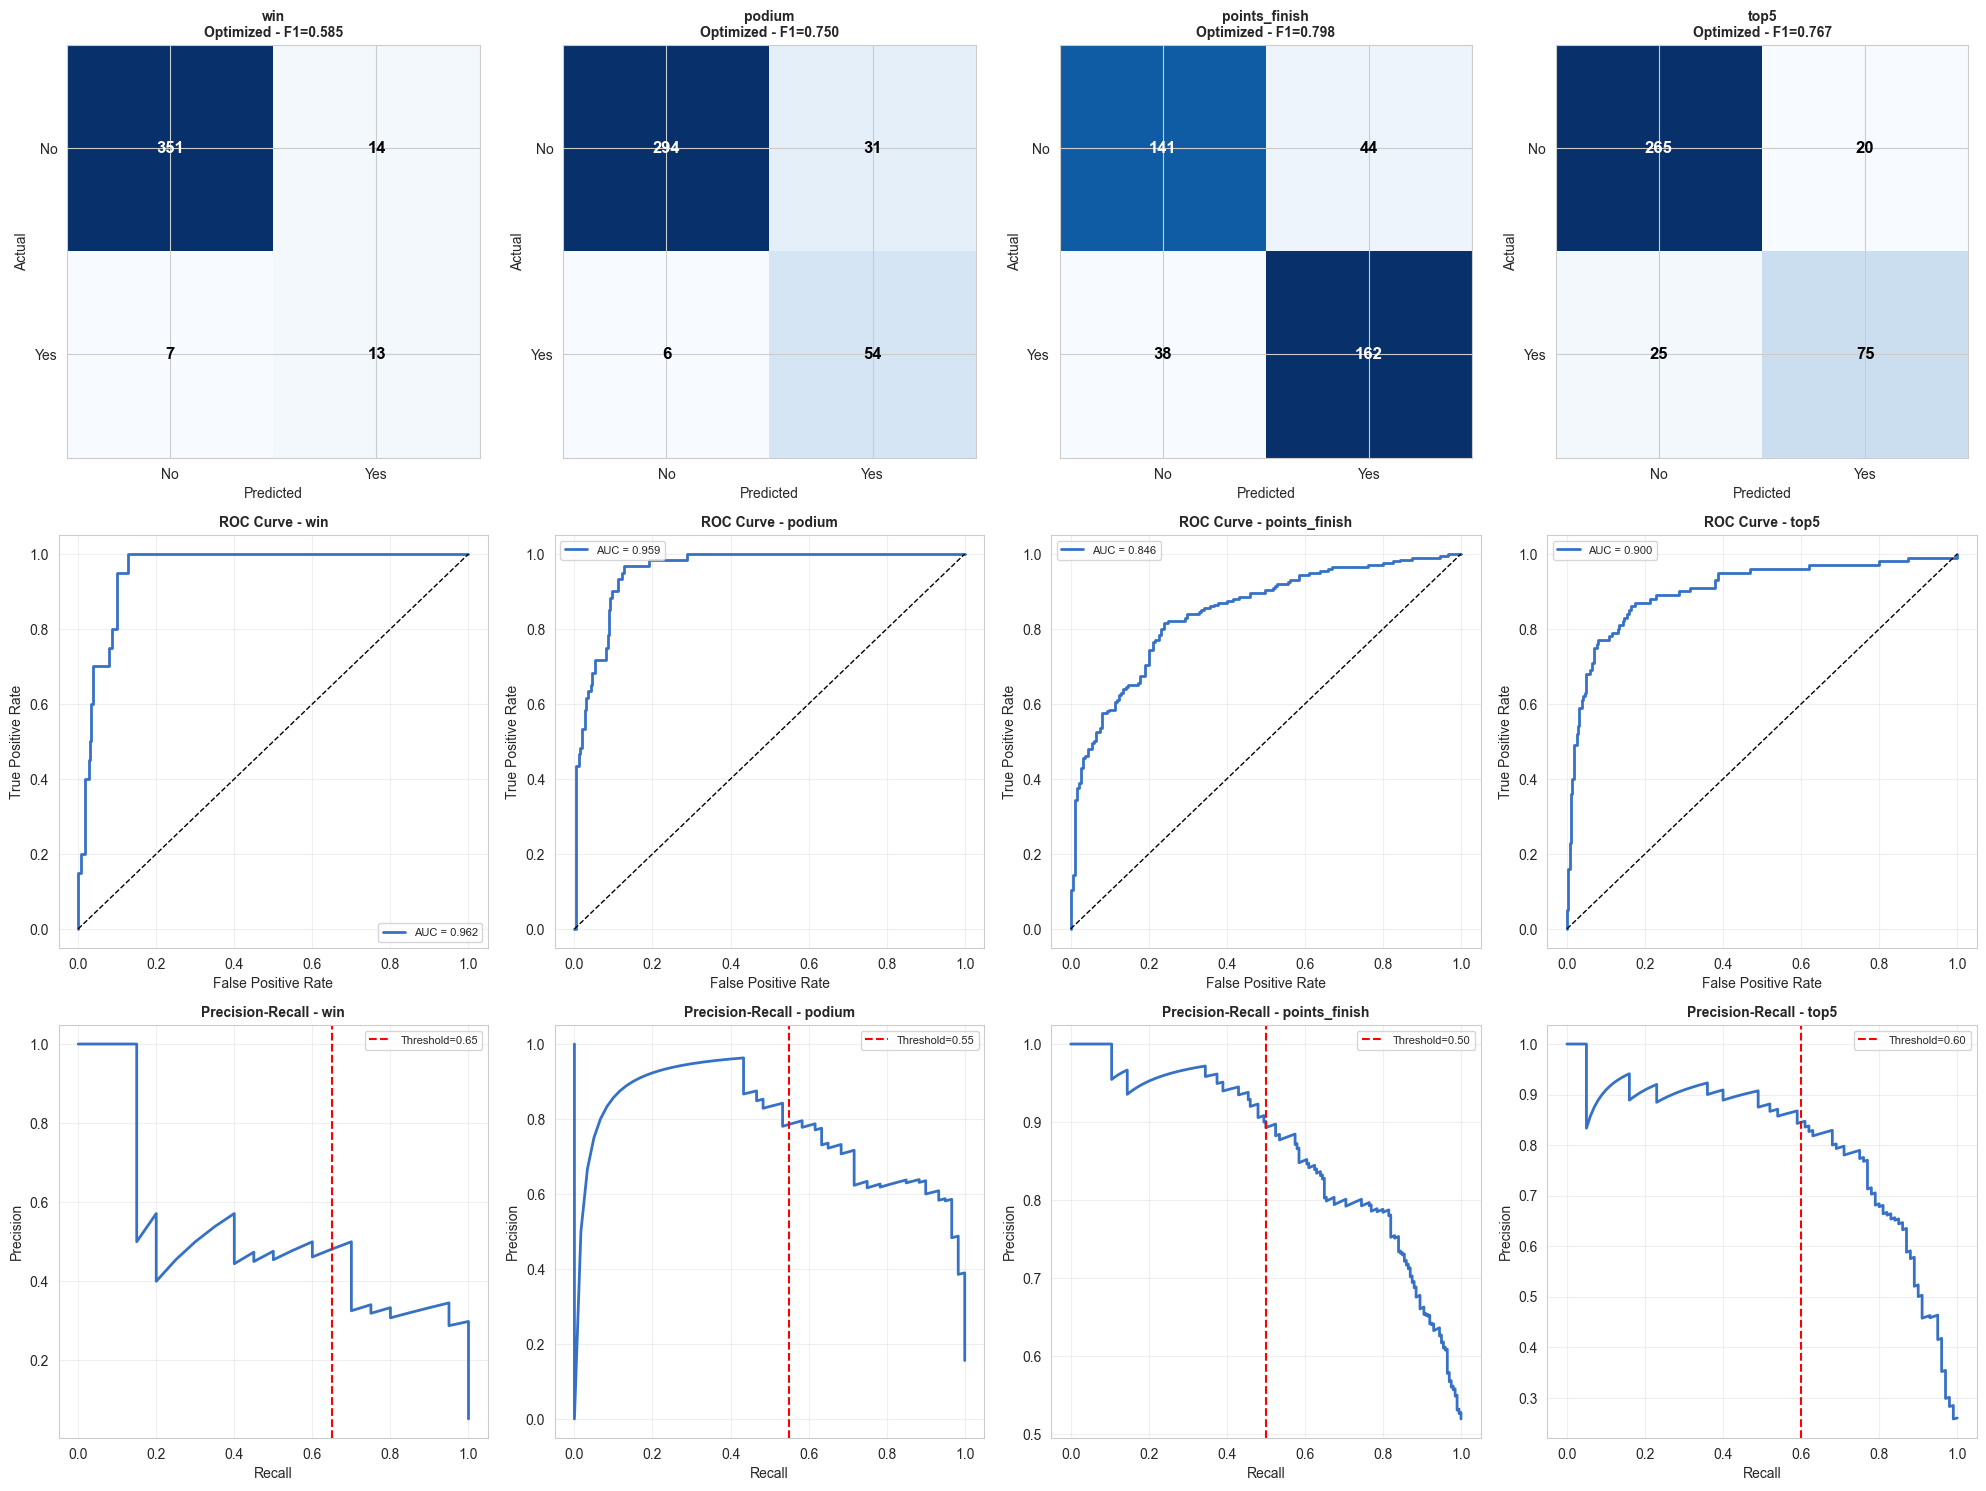

‚úÖ Detailed visualizations complete!


In [15]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for idx, target in enumerate(classification_targets):
    # Determine which model is better
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 > baseline_f1:
        best_results = optimized_class_results[target]
        model_label = "Optimized"
        color = '#3671C6'
    else:
        best_results = baseline_class_results[target]
        model_label = "Baseline"
        color = '#E10600'
    
    # Row 1: Confusion Matrix
    cm = confusion_matrix(y_test_class[target], best_results['test_pred_optimized'])
    axes[0, idx].imshow(cm, cmap='Blues')
    axes[0, idx].set_title(f'{target}\n{model_label} - F1={best_results["test_metrics_optimized"]["F1"]:.3f}', 
                           fontweight='bold', fontsize=10)
    axes[0, idx].set_xlabel('Predicted')
    axes[0, idx].set_ylabel('Actual')
    axes[0, idx].set_xticks([0, 1])
    axes[0, idx].set_yticks([0, 1])
    axes[0, idx].set_xticklabels(['No', 'Yes'])
    axes[0, idx].set_yticklabels(['No', 'Yes'])
    
    for i in range(2):
        for j in range(2):
            axes[0, idx].text(j, i, str(cm[i, j]), ha='center', va='center',
                             color='white' if cm[i, j] > cm.max()/2 else 'black',
                             fontsize=12, fontweight='bold')
    
    # Row 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_class[target], best_results['test_prob'])
    axes[1, idx].plot(fpr, tpr, color=color, lw=2, 
                     label=f'AUC = {best_results["test_metrics_optimized"]["AUC"]:.3f}')
    axes[1, idx].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[1, idx].set_xlabel('False Positive Rate')
    axes[1, idx].set_ylabel('True Positive Rate')
    axes[1, idx].set_title(f'ROC Curve - {target}', fontweight='bold', fontsize=10)
    axes[1, idx].legend(fontsize=8)
    axes[1, idx].grid(alpha=0.3)
    
    # Row 3: Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(
        y_test_class[target], best_results['test_prob']
    )
    axes[2, idx].plot(recall, precision, color=color, lw=2)
    axes[2, idx].axvline(best_results['optimal_threshold'], color='red', 
                        linestyle='--', label=f'Threshold={best_results["optimal_threshold"]:.2f}')
    axes[2, idx].set_xlabel('Recall')
    axes[2, idx].set_ylabel('Precision')
    axes[2, idx].set_title(f'Precision-Recall - {target}', fontweight='bold', fontsize=10)
    axes[2, idx].legend(fontsize=8)
    axes[2, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("‚úÖ Detailed visualizations complete!")

## Step 10 : Feature Importance Analysis


üìä Analyzing best performer: 'points_finish'

üèÜ TOP 15 FEATURES (points_finish - Optimized model):

quali_position                      ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 0.2795
q3_gap_to_pole                      ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 0.1669
grid_position                       ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 0.1069
driver_id                           ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 0.0563
driver_circuit_weighted_points      ‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà 0.0499
weighted_points_5                   ‚ñà‚ñà‚ñà‚ñà‚ñà 0.0360
avg_quali_position_5                ‚ñà‚ñà‚ñà‚ñà‚ñà 0.0340
driver_circuit_weighted_points      ‚ñà‚ñà‚ñà‚ñà 0.0331
driver_circuit_weighted_pos         ‚ñà‚ñà‚ñà‚ñà 0.0325
driver_circuit_weighted_pos         ‚ñà‚ñà‚ñà‚ñà 0.0322
team_weighted_points_5              ‚ñà‚ñà‚ñà 0.0249
team_id                             ‚ñà‚ñà‚ñ

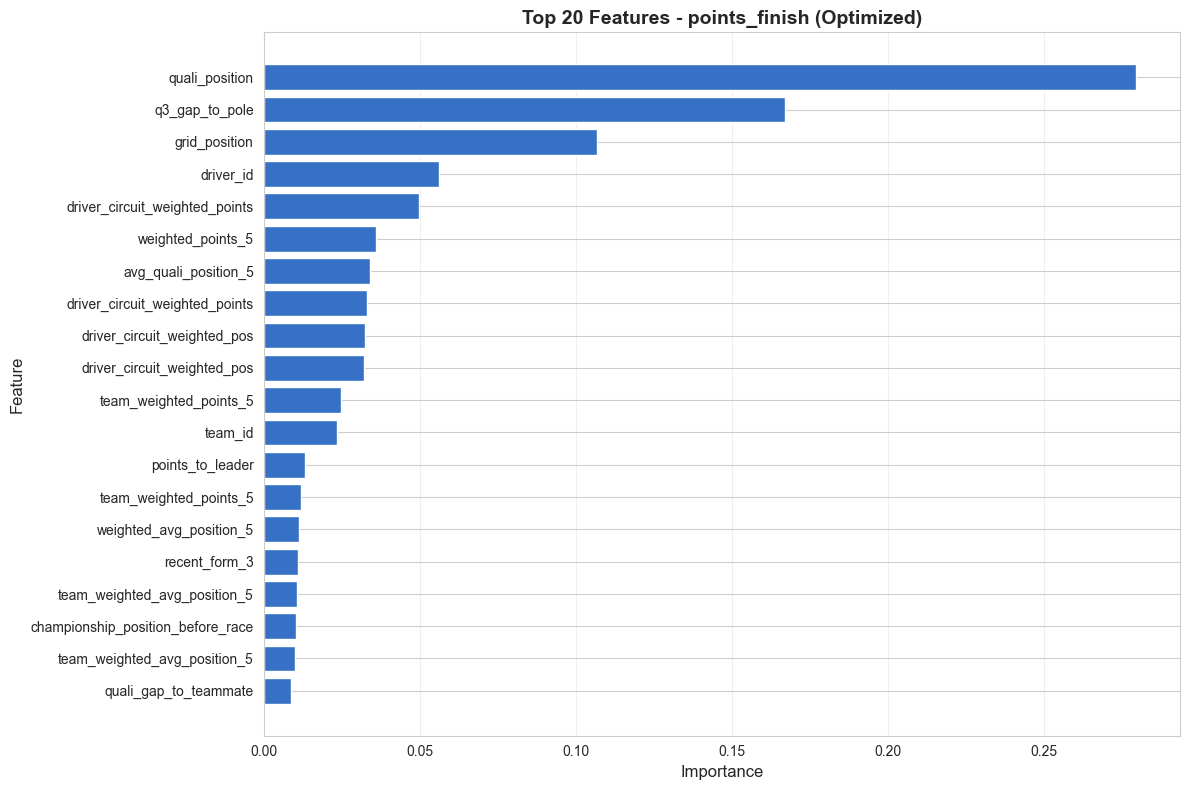

In [16]:
best_target = comparison_df.loc[comparison_df['Optimized_F1'].idxmax(), 'Target']
print(f"\nüìä Analyzing best performer: '{best_target}'")

if optimized_class_results[best_target]['test_metrics_optimized']['F1'] > \
   baseline_class_results[best_target]['test_metrics_optimized']['F1']:
    best_model = optimized_class_models[best_target]
    model_type = "Optimized"
else:
    best_model = baseline_class_models[best_target]
    model_type = "Baseline"

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nüèÜ TOP 15 FEATURES ({best_target} - {model_type} model):\n")
for idx, row in feature_importance.head(15).iterrows():
    bar = '‚ñà' * int(row['importance'] * 150)
    print(f"{row['feature'][:35]:35s} {bar} {row['importance']:.4f}")

# Visualize
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='#3671C6')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top 20 Features - {best_target} ({model_type})', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 11 : Save Best Classification Models

In [20]:
os.makedirs('../models', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

saved_files = []

print("\n" + "="*80)
print("üíæ SAVING BEST CLASSIFICATION MODELS")
print("="*80)

for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 > baseline_f1:
        model_to_save = optimized_class_models[target]
        results = optimized_class_results[target]
        model_type = "Optimized"
    else:
        model_to_save = baseline_class_models[target]
        results = baseline_class_results[target]
        model_type = "Baseline"
    
    # Save model
    model_path = f'../models/RF_Classifier_{target}_{model_type}_v2_{timestamp}.pkl'
    joblib.dump(model_to_save, model_path)
    saved_files.append(model_path)
    
    print(f"\n‚úÖ {target:15s}: {model_type:10s} | F1={results['test_metrics_optimized']['F1']:.3f} | "
          f"Threshold={results['optimal_threshold']:.2f}")

# Save metadata
metadata_dict = {
    'timestamp': datetime.now().isoformat(),
    'version': 'v2_improved',
    'features': feature_cols,
    'classification_targets': classification_targets,
    'models': {}
}

for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    if optimized_f1 > baseline_f1:
        results = optimized_class_results[target]
        model_type = "Optimized"
    else:
        results = baseline_class_results[target]
        model_type = "Baseline"
    
    metadata_dict['models'][target] = {
        'model_type': model_type,
        'test_f1': float(results['test_metrics_optimized']['F1']),
        'test_auc': float(results['test_metrics_optimized']['AUC']),
        'optimal_threshold': float(results['optimal_threshold']),
        'test_accuracy': float(results['test_metrics_optimized']['Accuracy']),
        'test_precision': float(results['test_metrics_optimized']['Precision']),
        'test_recall': float(results['test_metrics_optimized']['Recall'])
    }

metadata_path = f'../models/RF_Classification_Metadata_v2_{timestamp}.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_dict, f, indent=2)
saved_files.append(metadata_path)

# Save comparison
comparison_path = f'../models/RF_Classification_Comparison_v2_{timestamp}.csv'
comparison_df.to_csv(comparison_path, index=False)
saved_files.append(comparison_path)

print(f"\nüíæ Metadata: {metadata_path}")
print(f"üìä Comparison: {comparison_path}")
print(f"\n‚úÖ All classification files saved! Total: {len(saved_files)} files")



üíæ SAVING BEST CLASSIFICATION MODELS

‚úÖ win            : Optimized  | F1=0.585 | Threshold=0.65

‚úÖ podium         : Optimized  | F1=0.750 | Threshold=0.55

‚úÖ points_finish  : Optimized  | F1=0.798 | Threshold=0.50

‚úÖ top5           : Optimized  | F1=0.767 | Threshold=0.60

üíæ Metadata: ../models/RF_Classification_Metadata_v2_20251101_170900.json
üìä Comparison: ../models/RF_Classification_Comparison_v2_20251101_170900.csv

‚úÖ All classification files saved! Total: 6 files


## Classification Summary

In [19]:
print("\nüìä BEST MODELS PERFORMANCE (with optimized thresholds):\n")
for target in classification_targets:
    baseline_f1 = baseline_class_results[target]['test_metrics_optimized']['F1']
    optimized_f1 = optimized_class_results[target]['test_metrics_optimized']['F1']
    
    best_f1 = max(baseline_f1, optimized_f1)
    model_type = "Optimized" if optimized_f1 > baseline_f1 else "Baseline"
    results = optimized_class_results[target] if optimized_f1 > baseline_f1 else baseline_class_results[target]
    
    print(f"   {target:15s} | {model_type:10s} | F1: {best_f1:.3f} | "
          f"AUC: {results['test_metrics_optimized']['AUC']:.3f} | "
          f"Acc: {results['test_metrics_optimized']['Accuracy']:.3f} | "
          f"Pre: {results['test_metrics_optimized']['Precision']:.3f} |"
          f"Rec: {results['test_metrics_optimized']['Recall']:.3f} |" )

print("\nüí° KEY IMPROVEMENTS:")
print("   ‚úÖ Used shallower trees to prevent overfitting")
print("   ‚úÖ Higher min_samples constraints for regularization")
print("   ‚úÖ Stratified K-Fold CV for imbalanced classes")
print("   ‚úÖ Optimized probability thresholds per target")
print("   ‚úÖ Learning curve analysis to detect overfitting")


üìä BEST MODELS PERFORMANCE (with optimized thresholds):

   win             | Optimized  | F1: 0.585 | AUC: 0.962 | Acc: 0.949 | Pre: 0.511 |Rec: 0.684 |
   podium          | Optimized  | F1: 0.750 | AUC: 0.959 | Acc: 0.906 | Pre: 0.643 |Rec: 0.899 |
   points_finish   | Optimized  | F1: 0.798 | AUC: 0.846 | Acc: 0.787 | Pre: 0.789 |Rec: 0.807 |
   top5            | Optimized  | F1: 0.767 | AUC: 0.900 | Acc: 0.882 | Pre: 0.792 |Rec: 0.744 |

üí° KEY IMPROVEMENTS:
   ‚úÖ Used shallower trees to prevent overfitting
   ‚úÖ Higher min_samples constraints for regularization
   ‚úÖ Stratified K-Fold CV for imbalanced classes
   ‚úÖ Optimized probability thresholds per target
   ‚úÖ Learning curve analysis to detect overfitting
